Example of explaining binary mnist with KernelSHAP <br>

Function : Explaining binary mnist with KernelSHAP <br>
Author : Team DIANNA <br>
Contributor : <br>
First Built : 2022.01.06 <br>
Last Update : 2022.01.07 <br>

In [1]:
import numpy as np
from pathlib import Path
import onnx
from onnx_tf.backend import prepare
import matplotlib.pyplot as plt
from dianna.methods import KernelSHAP

/home/yangliu/miniconda3/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.5.0 and strictly below 2.8.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.4.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


### Load data (binary MNIST)

In [2]:
# load binary MNIST from local
# load data
fd = np.load(Path('binary-mnist.npz'))
# training set
train_X = fd['X_train'] / 255
train_y = fd['y_train']
# testing set
test_X = fd['X_test'] / 255
test_y = fd['y_test']
fd.close()

# dimensions of data
print("dimensions of mnist:")
print("dimensions or training set", train_X.shape)
print("dimensions or training set label", train_y.shape)
print("dimensions or testing set", test_X.shape)
print("dimensions or testing set label", test_y.shape)
# statistics of training set
print("statistics of training set:")
print("Digits: 0 1")
print("labels: {}".format(np.unique(train_y)))
print("Class distribution: {}".format(np.bincount(train_y)))
print("Labels of training set", train_y[:20])

dimensions of mnist:
dimensions or training set (12665, 784)
dimensions or training set label (12665,)
dimensions or testing set (2115, 784)
dimensions or testing set label (2115,)
statistics of training set:
Digits: 0 1
labels: [0 1]
Class distribution: [5923 6742]
Labels of training set [0 1 1 1 1 0 1 1 0 0 1 0 0 1 0 1 0 0 1 1]


In [3]:
# reshape the input following the definition in pytorch (batch, channel, Height, Width)
test_X = test_X.reshape(-1,28,28,1)
# choose the image for explanation
test_sample = test_X[1:2,:,:,:]

In [4]:
import tensorflow
# Load saved onnx model
onnx_model_path = "../tests/test_data/mnist_model_tf.onnx"
onnx_model = onnx.load(onnx_model_path)
output_node = prepare(onnx_model, gen_tensor_dict=True).outputs[0]

2022-01-11 15:14:07.336122: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-11 15:14:07.336690: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-11 15:14:07.337764: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [5]:
# use Kernel SHAP to explain the network's predictions
axes_labels = ('batch', 'height', 'width', 'channels')
explainer = KernelSHAP()
shap_values, segments_slic = explainer.explain_image(onnx_model_path, test_sample, nsamples=1000,
                                      background=0, n_segments=200, sigma=0,
                                      axes_labels = axes_labels)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-01-11 15:14:09.781168: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-01-11 15:14:09.784569: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2304005000 Hz


  0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
# model predictions
predictions = prepare(onnx_model).run(np.expand_dims(test_sample.copy().astype(np.float32),
                                      axis=0))[f'{output_node}']
top_preds = np.argsort(-predictions)

In [7]:
# fill each pixel with shap values based on the segmentation
def fill_segmentation(values, segmentation):
    out = np.zeros(segmentation.shape)
    for i in range(len(values)):
        out[segmentation == i] = values[i]
    return out

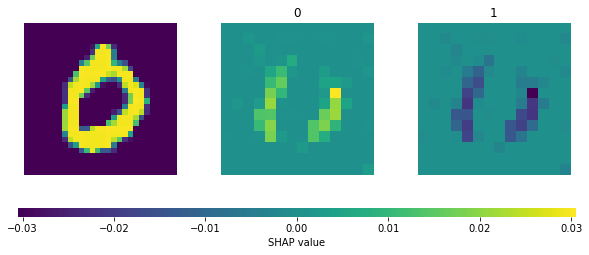

In [10]:
# Visualize the explanations
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,4))
inds = top_preds[0]
axes[0].imshow(test_sample[0])
axes[0].axis('off')
# get the range for color bar
max_val = np.max([np.max(np.abs(shap_values[i][:,:-1])) for i in range(len(shap_values))])
for i in range(2):
    m = fill_segmentation(shap_values[inds[i]][0], segments_slic)
    axes[i+1].set_title(str(inds[i]))
    axes[i+1].imshow(test_sample[0], alpha=0.15)
    im = axes[i+1].imshow(m, vmin=-max_val, vmax=max_val)
    axes[i+1].axis('off')
cb = fig.colorbar(im, ax=axes.ravel().tolist(), label="SHAP value", orientation="horizontal", aspect=60)
cb.outline.set_visible(False)
plt.show()